# Modeling the distribution of neural networks
> An attempt to characterize the distribution of neural network parameters that are learned on the same task

- toc: true
- badges: true
- categories: [pedigo, graspologic]
- hide: false
- search_exclude: false

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from graspy.plot import heatmap, pairplot
from scipy.stats import pearsonr, spearmanr
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.match import GraphMatch
from src.io import savefig
from src.visualization import set_theme

FNAME = os.path.basename(__file__)[:-3]
print(FNAME)

set_theme()


def stashfig(name, **kws):
    savefig(name, foldername=FNAME, save_on=True, **kws)



188.0-BDP-nn-genes


## Trying to learn distributions on NNs trained on the same task

### Example training and predicted labels
 Adapted from Sklearn docs

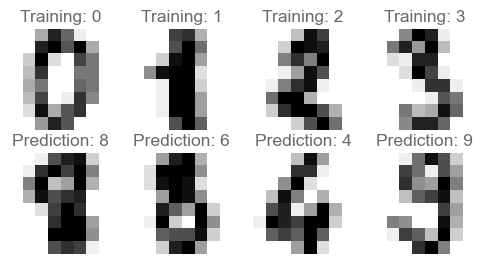

In [2]:
# The digits dataset
digits = load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label, fontsize="x-small")

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
# classifier = svm.SVC(gamma=0.001)
classifier = MLPClassifier()

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2 :], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Prediction: %i" % prediction, fontsize="x-small")



### Training multiple NNs on the same task

In [3]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

n_replicates = 8
adjs = []
all_biases = []
all_weights = []
for i in range(n_replicates):
    X_train, X_test, y_train, y_test = train_test_split(
        data, digits.target, test_size=0.3, shuffle=True
    )
    mlp = MLPClassifier(hidden_layer_sizes=(50, 50))
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    weights_by_layer = mlp.coefs_
    all_biases.append(mlp.intercepts_)
    all_weights.append(mlp.coefs_)

    print(f"Test accuracy score for NN {i+1}: {acc}")

    n_nodes = 0
    for weights in weights_by_layer:
        n_source, n_target = weights.shape
        n_nodes += n_source
    n_nodes += n_target
    adj = np.zeros((n_nodes, n_nodes))

    n_nodes_visited = 0
    for i, weights in enumerate(weights_by_layer):
        n_source, n_target = weights.shape
        adj[
            n_nodes_visited : n_nodes_visited + n_source,
            n_nodes_visited + n_source : n_nodes_visited + n_source + n_target,
        ] = weights
        n_nodes_visited += n_source
    adjs.append(adj)


all_biases = [np.concatenate(b) for b in all_biases]
all_biases = np.stack(all_biases).T

all_weights = [[w.ravel() for w in weights] for weights in all_weights]
all_weights = [np.concatenate(w) for w in all_weights]
all_weights = np.stack(all_weights).T

Test accuracy score for NN 1: 0.9740740740740741
Test accuracy score for NN 2: 0.9611111111111111
Test accuracy score for NN 3: 0.9796296296296296
Test accuracy score for NN 4: 0.9703703703703703
Test accuracy score for NN 5: 0.975925925925926
Test accuracy score for NN 6: 0.9462962962962963
Test accuracy score for NN 7: 0.9814814814814815
Test accuracy score for NN 8: 0.9722222222222222


### Plotting the adjacency matrices for each NN

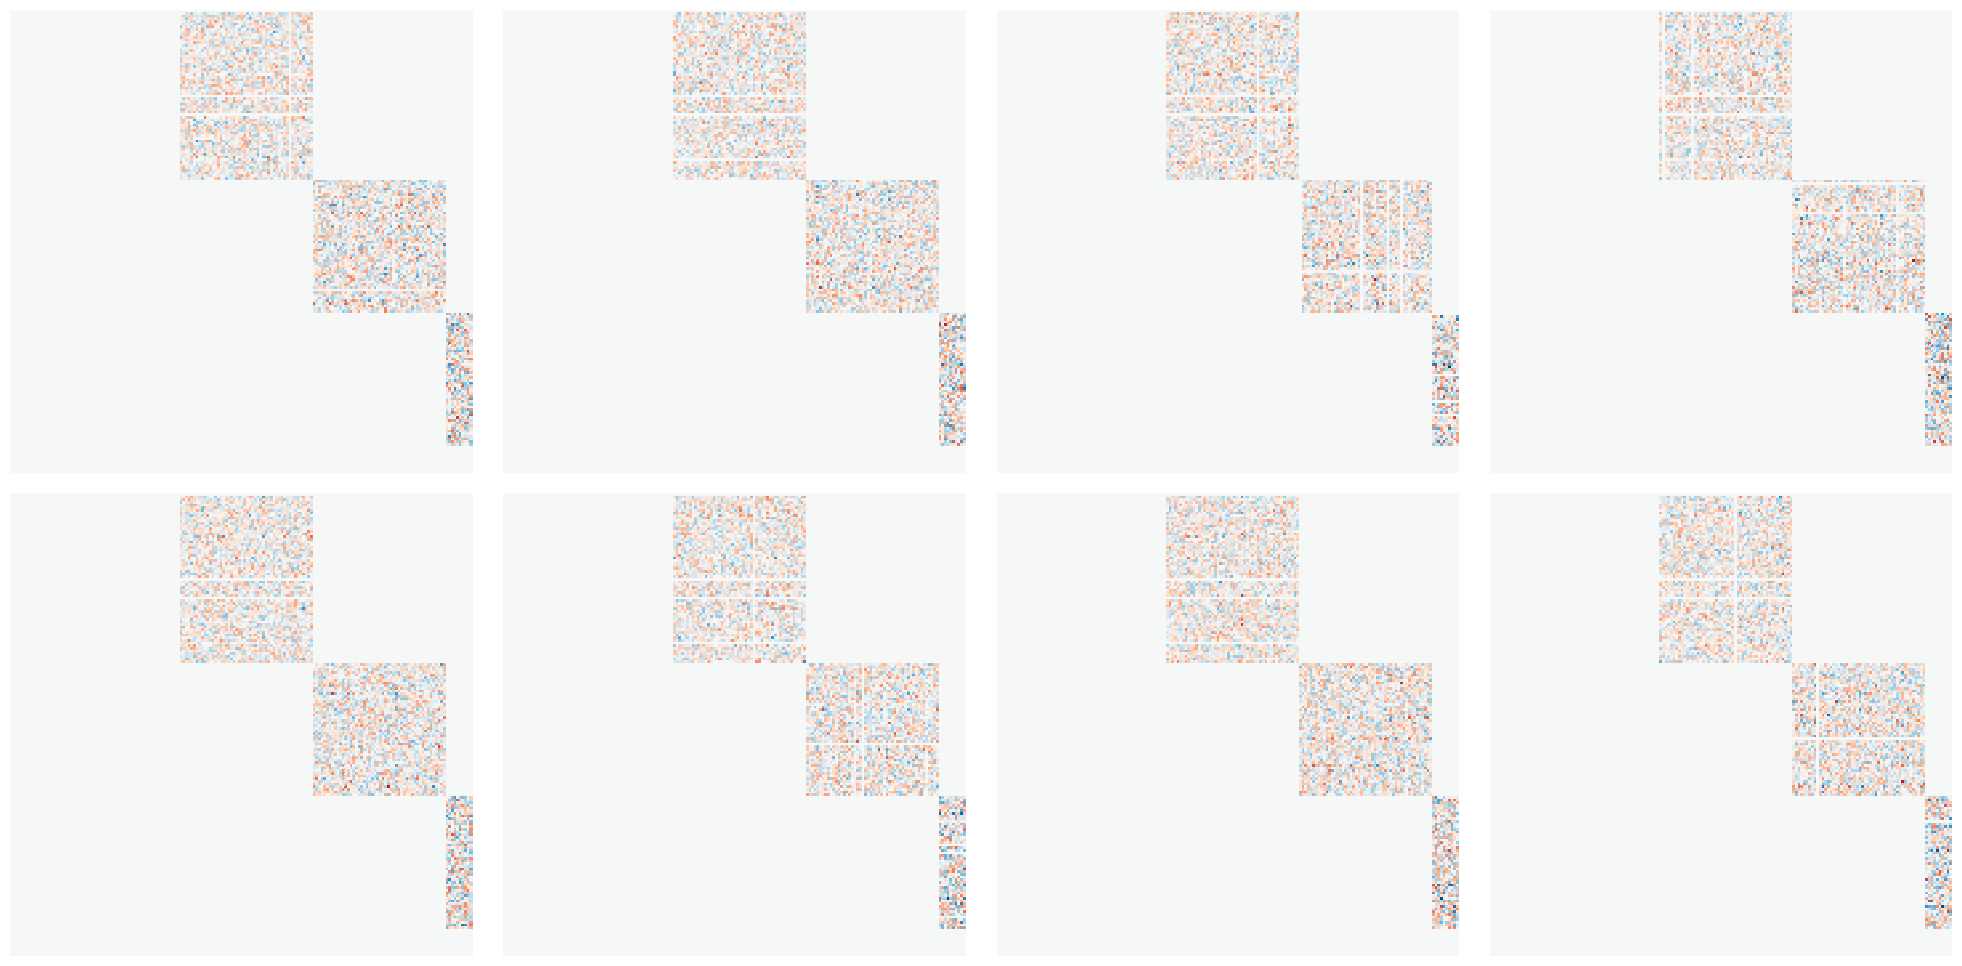

In [4]:
vmax = max(map(np.max, adjs))
vmin = min(map(np.min, adjs))
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axs.ravel()):
    heatmap(adjs[i], cbar=False, vmin=vmin, vmax=vmax, ax=ax)
plt.tight_layout()



### Trying to model the weights with something simple
 Here I just take the mean adjacency matrix, and do a low-rank decomposition.

<AxesSubplot:title={'center':'Low-rank weights'}>

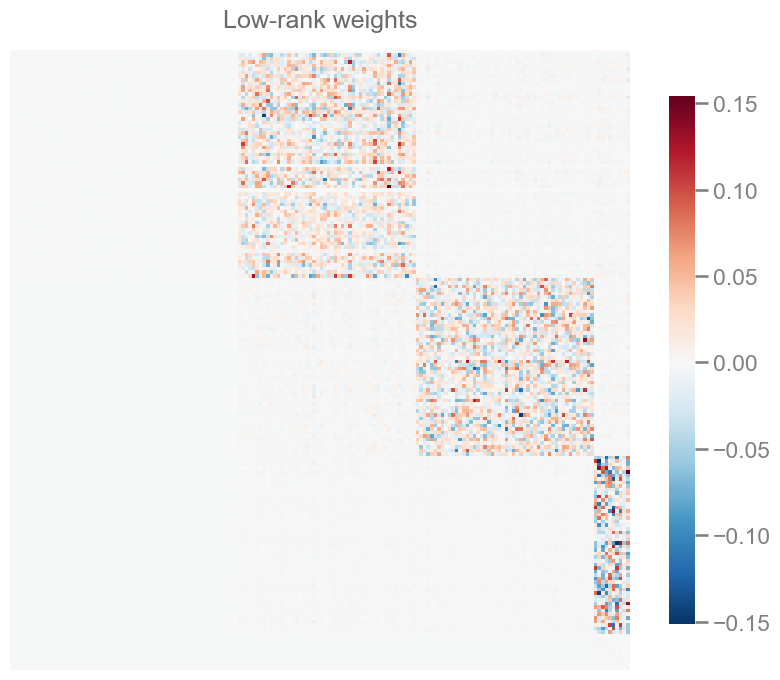

In [5]:
adj_bar = np.mean(np.stack(adjs), axis=0)
ase = AdjacencySpectralEmbed(n_components=20)
X, Y = ase.fit_transform(adj_bar)
P_hat = X @ Y.T
heatmap(P_hat, title="Low-rank weights")


 Then I make a new NN where the weights are set to this low rank matrix, and see how it
 performs.

 NB: what to do with the bias vectors here? Right now I'm just setting to 0.

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(50, 50))
mlp.fit(
    X_train, y_train
)  # dummy fit, just to set parameters like shape of input/output

n_nodes_visited = 0
for i, weights in enumerate(weights_by_layer):
    n_source, n_target = weights.shape
    mlp.coefs_[i] = P_hat[
        n_nodes_visited : n_nodes_visited + n_source,
        n_nodes_visited + n_source : n_nodes_visited + n_source + n_target,
    ]
    n_nodes_visited += n_source
    mlp.intercepts_[i][:] = 0
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy score for NN with low-rank weights: {acc}")


Test accuracy score for NN with low-rank weights: 0.17222222222222222


## Why I think this doesn't work, and what we might be able to do about it
 There are two big issues as I see it:
 - Permuation nonidentifiability in the model
 - Lack of edge-edge dependence structure in our models
 Below I investigate the first issue, haven't thought about what to do for the second

### Plotting the learned weights against each other
 If each network has $d$ free weight parameters, and there are $T$ of them,
 I form the $T$ by $d$ matrix of weights per neural network, and then plot each network's
 weights against each other.

Saved figure to maggot_models/notebooks/outs/188.0-BDP-nn-genes/figs/weight-pairplot.png


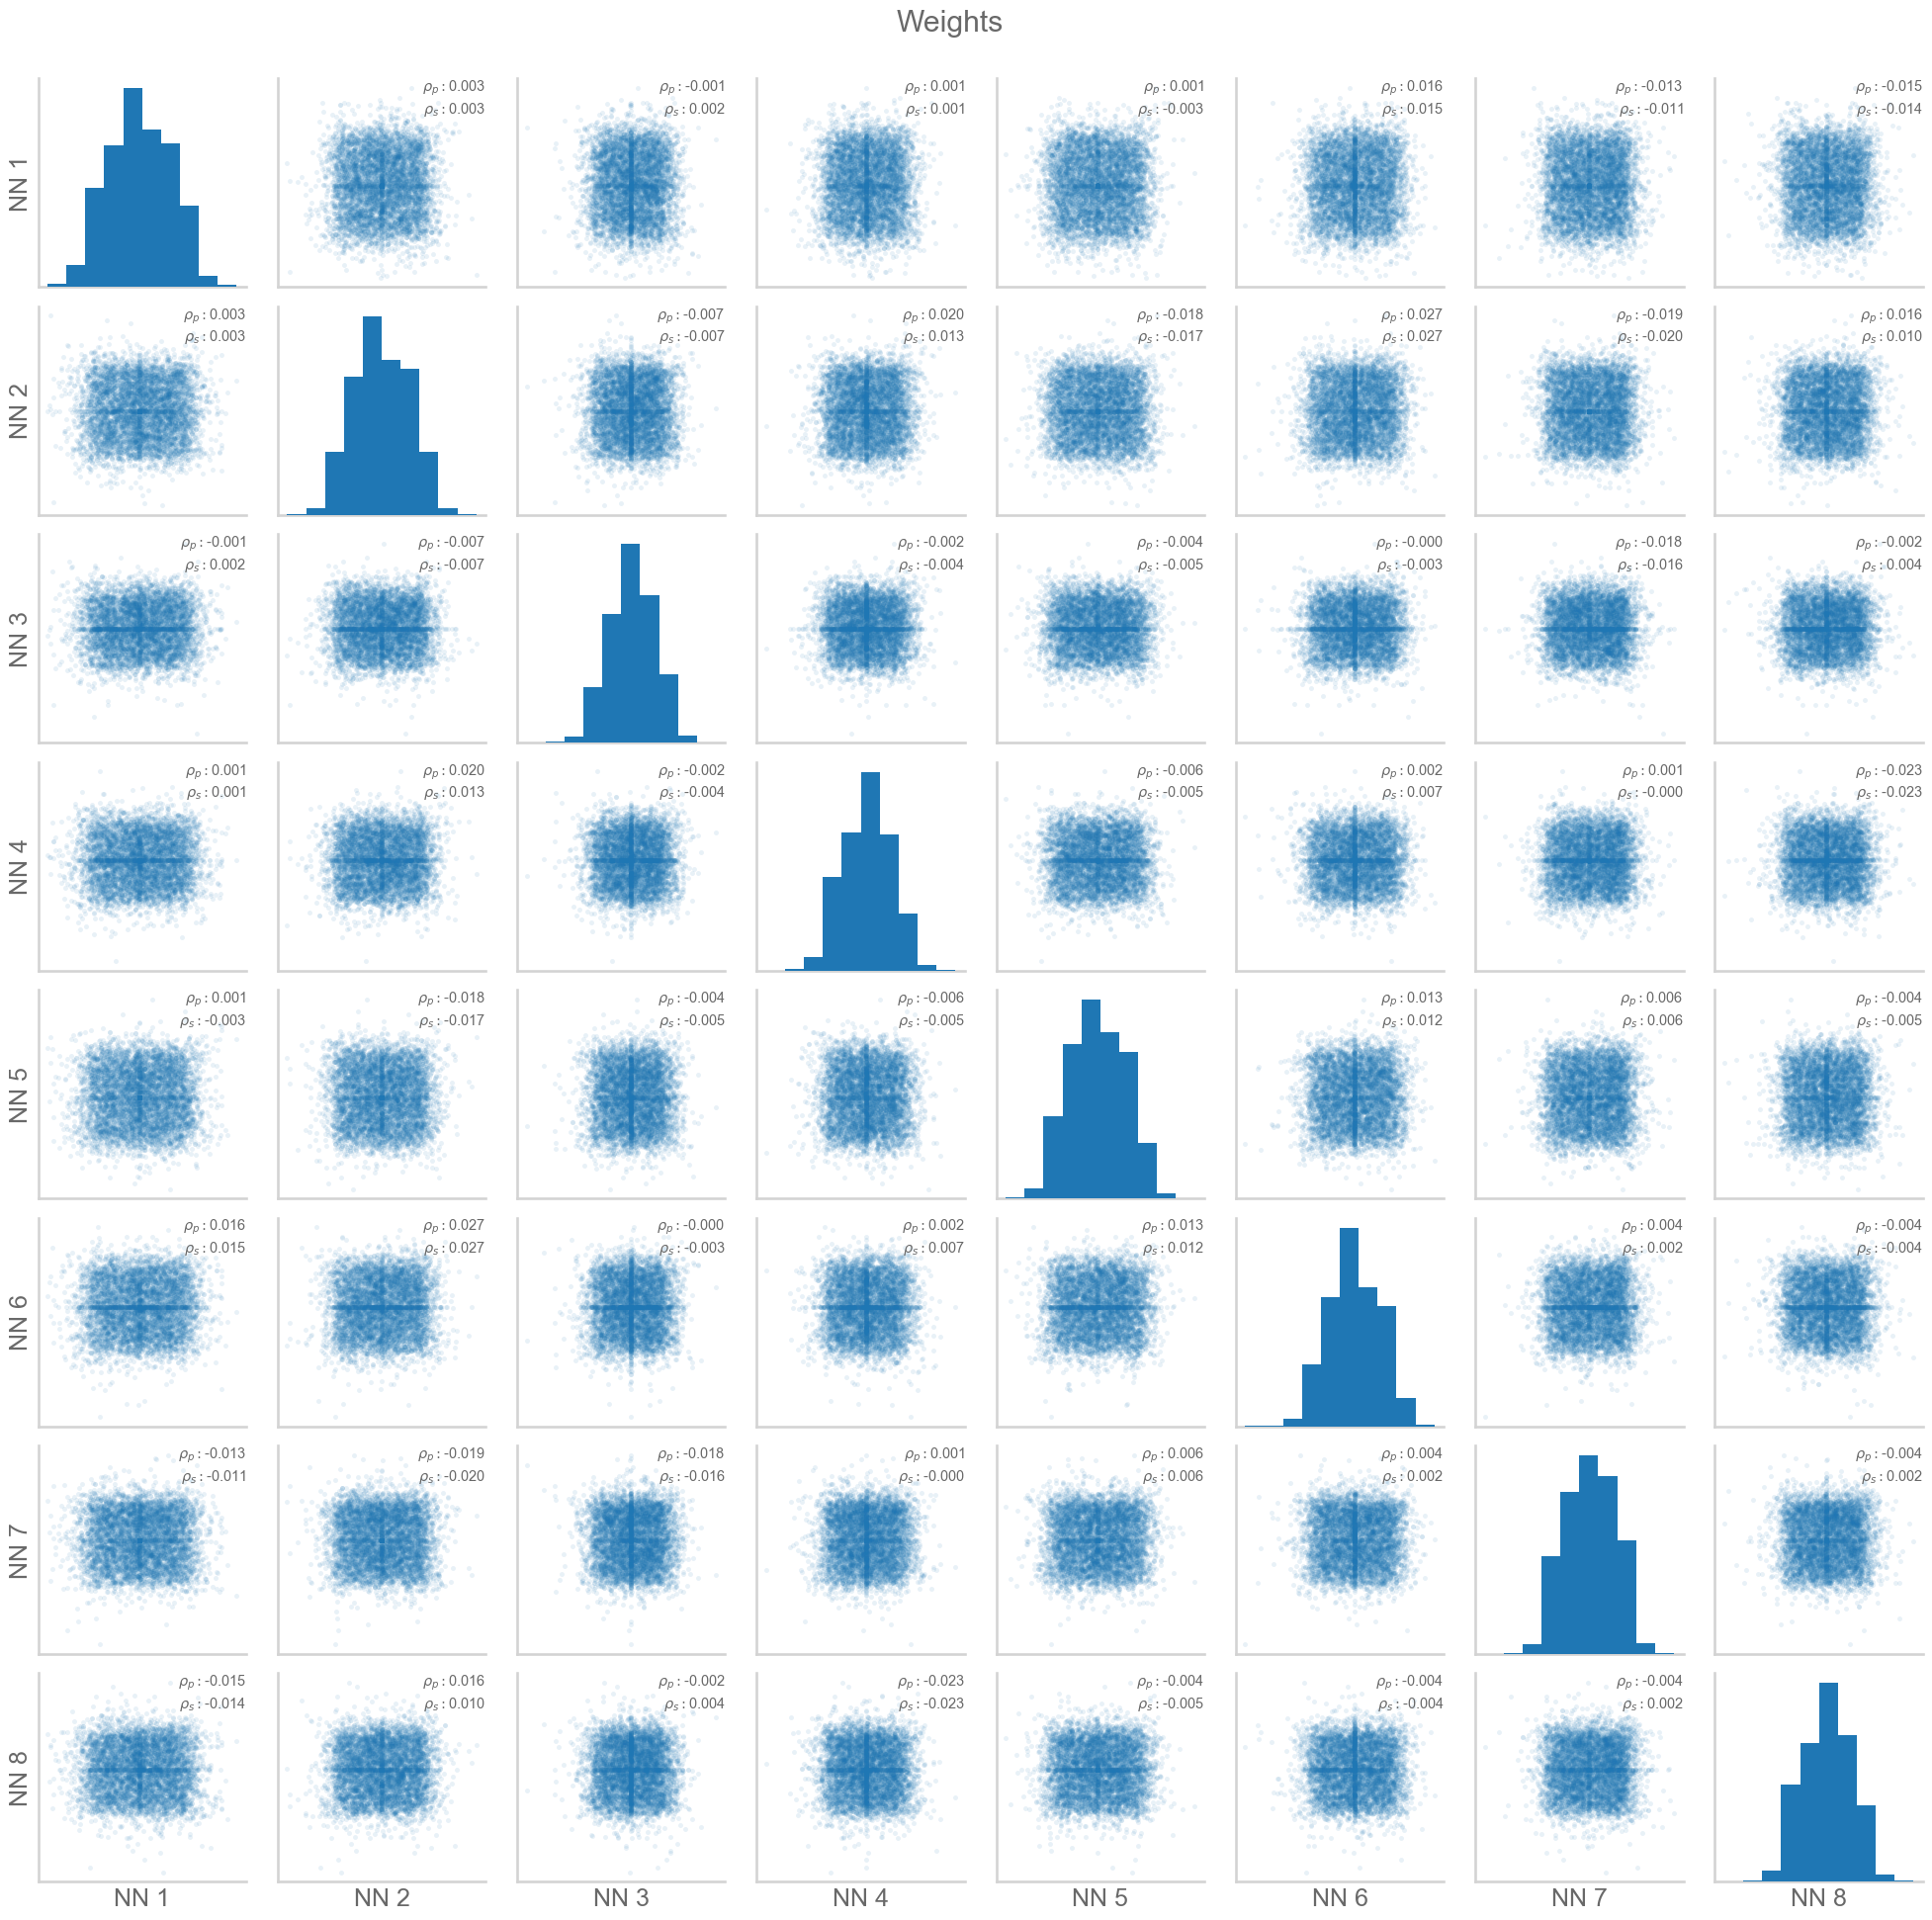

In [7]:


def corrplot(x, y, *args, ax=None, fontsize="xx-small", **kwargs):
    if ax is None:
        ax = plt.gca()
    pearsons, _ = pearsonr(x, y)
    spearmans, _ = spearmanr(x, y)
    text = r"$\rho_p: $" + f"{pearsons:.3f}\n"
    text += r"$\rho_s: $" + f"{spearmans:.3f}"
    ax.text(1, 1, text, ha="right", va="top", transform=ax.transAxes, fontsize=fontsize)


pg = pairplot(
    all_weights,
    alpha=0.1,
    title="Weights",
    col_names=[f"NN {i+1}" for i in range(all_weights.shape[1])],
)
pg.map_offdiag(corrplot)
stashfig(
    "weight-pairplot",
)


### Can graph matching fix the permutation nonidentifiability?
 Given one neural network architecture, one could permute the labels/orders of the hidden
 units, and the network would be functionally equivalent. This means that when comparing the
 architectures of two learned neural networks against each other, there is a nonidentifiability
 problem caused by this arbitrary permutation. Even if we imagine that two neural networks
 learned the exact same weights, they are unlikely to look similar at a glance because it
 is unlikely they learned the same weights and the same permutation. Let's see if graph matching
 can help resolve this nonidentifiability.

Saved figure to maggot_models/notebooks/outs/188.0-BDP-nn-genes/figs/pre-gm-adjs.png
Saved figure to maggot_models/notebooks/outs/188.0-BDP-nn-genes/figs/post-gm-adjs.png
Saved figure to maggot_models/notebooks/outs/188.0-BDP-nn-genes/figs/pre-post-weights-gm.png


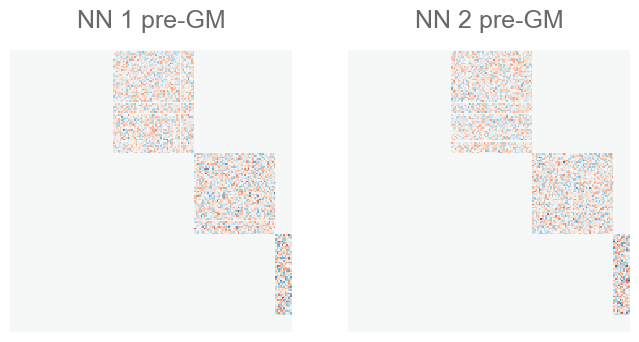

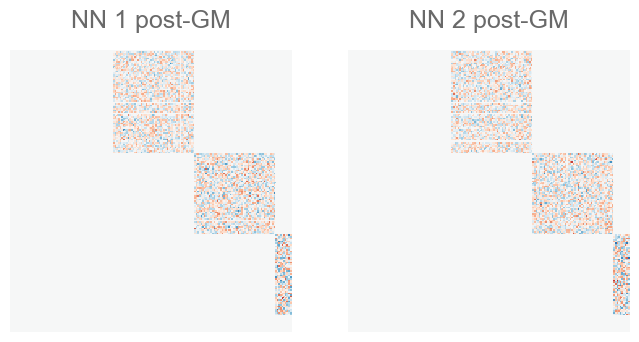

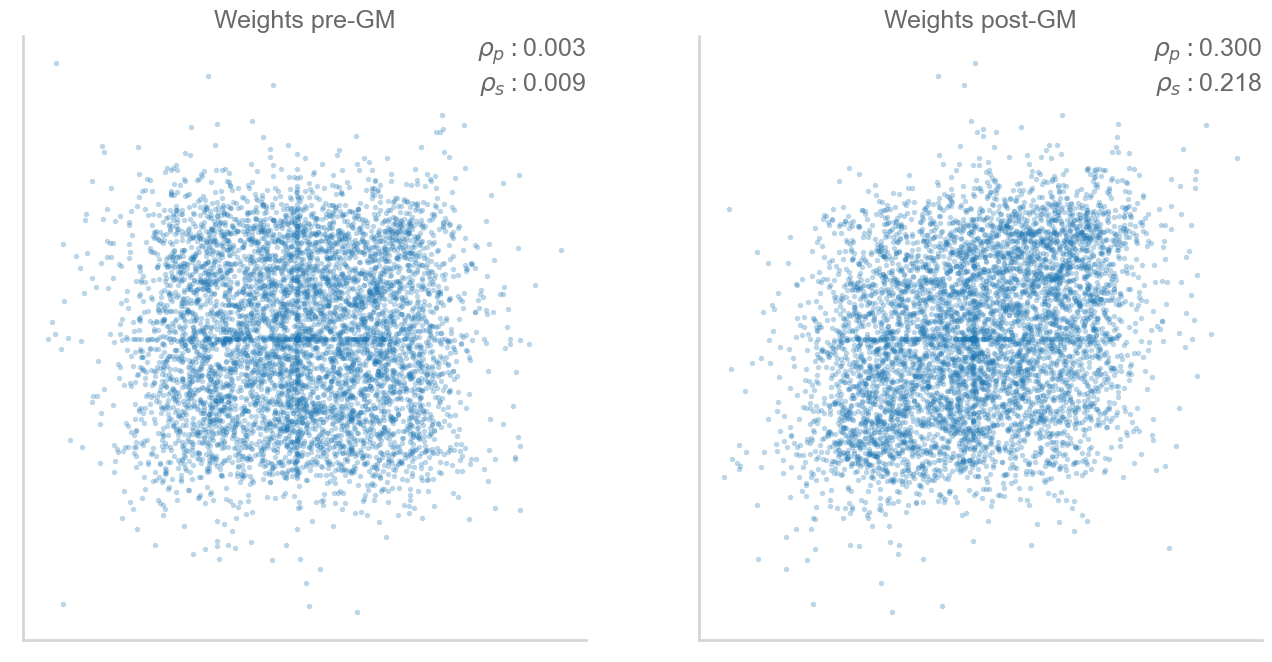

In [8]:
heatmap_kws = dict(vmin=vmin, vmax=vmax, cbar=False)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
heatmap(adjs[0], ax=axs[0], title="NN 1 pre-GM", **heatmap_kws)
heatmap(adjs[1], ax=axs[1], title="NN 2 pre-GM", **heatmap_kws)
stashfig("pre-gm-adjs")

seeds = np.concatenate((np.arange(data.shape[1]), np.arange(len(adj) - 10, len(adj))))

gm = GraphMatch(n_init=20, init_method="barycenter")
gm.fit(adjs[0], adjs[1], seeds_A=seeds, seeds_B=seeds)
perm_inds = gm.perm_inds_
adj_1_matched = adjs[1][np.ix_(perm_inds, perm_inds)].copy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
heatmap(adjs[0], ax=axs[0], title="NN 1 post-GM", **heatmap_kws)
heatmap(adj_1_matched, ax=axs[1], title="NN 2 post-GM", **heatmap_kws)
stashfig("post-gm-adjs")

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
ax = axs[0]
sns.scatterplot(adjs[0].ravel(), adjs[1].ravel(), ax=ax, alpha=0.3, linewidth=0, s=15)
corrplot(adjs[0].ravel(), adjs[1].ravel(), ax=ax, fontsize="medium")
ax.set(title="Weights pre-GM", xticks=[], yticks=[])
ax = axs[1]
sns.scatterplot(
    adjs[0].ravel(), adj_1_matched.ravel(), ax=ax, alpha=0.3, linewidth=0, s=15
)
corrplot(adjs[0].ravel(), adj_1_matched.ravel(), ax=ax, fontsize="medium")
ax.set(title="Weights post-GM", xticks=[], yticks=[])
stashfig("pre-post-weights-gm")



In [9]:
# def get_masks(mlp):
#     weights_by_layer = mlp.coefs_
#     n_nodes = 0
#     for weights in weights_by_layer:
#         n_source, n_target = weights.shape
#         n_nodes += n_source
#     n_nodes += n_target
#     union_mask = np.zeros((n_nodes, n_nodes), dtype=bool)

#     n_nodes_visited = 0
#     layer_masks = []
#     for i, weights in enumerate(weights_by_layer):
#         n_source, n_target = weights.shape
#         layer_mask = np.zeros((n_nodes, n_nodes), dtype=bool)
#         layer_mask[
#             n_nodes_visited : n_nodes_visited + n_source,
#             n_nodes_visited + n_source : n_nodes_visited + n_source + n_target,
#         ] = True
#         layer_masks.append(layer_mask)
#         union_mask[
#             n_nodes_visited : n_nodes_visited + n_source,
#             n_nodes_visited + n_source : n_nodes_visited + n_source + n_target,
#         ] = True
#         n_nodes_visited += n_source
#     return union_mask, layer_masks


# def get_weight_matrices(mlp):
#     union_mask, layer_masks = get_masks(mlp)
